In [3]:
from environment import Environment
from agent import Agent
from trainer import Final_variational_trainer, Q_learning_trainer
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import json
from easydict import EasyDict
from datetime import date
import os
import torch

# Environment Params

In [3]:
args = EasyDict()
args.ENV_NAME = 'Bottleneck' #'Pendulum-v0' #'CartPole-v1' #'MountainCar-v0' #'FrozenLake-v0' #
args.continuous=False

In [4]:
env = Environment.bottleneck(initial_state_range=0)

In [5]:
env.N_obs

18

# Trainer Params

In [6]:
args.monte_carlo=True
args.augmentation = True
args.final = True 



In [65]:
ALPHA_REF = 0.01 # le alpha qui sert à apprendre Q_ref (PREC inclus)
BETA_REF = 100 # amplification du reward

args.PREC = 3 / BETA_REF  # poids relatif des 2 termes dans la mise à jour explo/exploit
args.Q_VAR_MULT = 1

args.ALPHA = ALPHA_REF / args.Q_VAR_MULT / args.PREC  # la division par PREC assure la même "vitesse d'app"
                                                      # quelle que soit la valeur de PREC


args.OBS_LEAK = args.ALPHA / env.N_obs #1e-3  #3e-3 
# OBS_LEAK regule la valeur de KL (si faible : atténue les pics pour les etats 'nouveaux', favorise le 'turn over')



In [66]:
args.ALPHA, args.PREC, args.OBS_LEAK

(0.33333333333333337, 0.03, 0.01851851851851852)

# Agent Params

In [67]:
args.isTime = True
args.offPolicy = False
args.BETA = BETA_REF 

args.GAMMA = 1
args.do_reward = None
args.HIST_HORIZON = 200 * int(1/args.OBS_LEAK)

args.act_renorm = False
args.retain_present = False
args.retain_trajectory = False

args.KL_centering = True
args.rtg_centering = True

# Data path

In [68]:
data_path = "data/{}/{}-{}".format(args.ENV_NAME,str(date.today()),args.ENV_NAME)
if not args.final:
    data_path += '-full'
else:
    data_path += '-final'
if args.do_reward:
    data_path += '-do-reward'
else:
    data_path += '-no-reward'

data_path += '-LEAK-{}'.format(args.OBS_LEAK)
data_path += '-GAMMA-{}'.format(args.GAMMA)
data_path += '-BETA-{}'.format(args.BETA)
data_path += '-PREC-{}'.format(args.PREC)
data_path += '-ALPHA-{}'.format(ALPHA_REF)

if args.continuous:
    data_path += '-{}'.format(args.optim)
    if args.KNN_prob:
        data_path += '-KNN'    
    data_path += '-PART-{}'.format(args.N_PART)
    data_path += '-HIDDEN-{}'.format(args.N_HIDDEN)
    
    if args.retain_present:
        data_path += '-retain-pres'
    if args.retain_present:
        data_path += '-retain-traj'
    if args.KL_correction:
        data_path += '-KL-corr'
    if args.clip_gradients:
        data_path += '-clip-grad'


In [69]:
data_path_npy = data_path+'.npy'
data_path_json = data_path+'.json'
if args.continuous:
    data_path_Q_var = data_path+'-Q_var.pt'
    data_path_Q_ref = data_path+'-Q_ref.pt'
    data_path_Q_KL = data_path+'-Q_KL.pt'

In [70]:
if not os.path.isfile(data_path_json):
    with open(data_path_json, 'w') as fp:
        json.dump(args, fp)

In [71]:
data_path_npy

'data/Bottleneck/2021-04-22-Bottleneck-final-no-reward-LEAK-0.01851851851851852-GAMMA-1-BETA-100-PREC-0.03-ALPHA-0.01.npy'

In [93]:
N = 3000 # Number of episodes
NB_TRIALS = 1

In [94]:
args.do_reward = True

In [95]:
mem_Q_var = []
mem_Q_ref = []
BETA= args.BETA
agent = Agent(env,
              ALPHA=args.ALPHA,
              GAMMA=args.GAMMA, # Episodic agent!
              BETA=BETA, 
              PREC=args.PREC,
              do_reward=args.do_reward,
              isTime=args.isTime,    #!! TimeAgent
              offPolicy=False) 

In [96]:
trainer = Final_variational_trainer(agent, 
                                    monte_carlo=args.monte_carlo, 
                                    final= args.final,
                                    augmentation=args.augmentation,
                                    OBS_LEAK=args.OBS_LEAK,
                                    ref_prob='unif',
                                    KL_centering=args.KL_centering,
                                    rtg_centering=args.rtg_centering) #[2,5] # 

In [97]:
mem_total_reward = {}
nb_visits_final = {}

In [98]:
for trial in range(N):

    trainer.run_episode()
    mem_Q_var.append(np.array(agent.Q_var_tab))
    mem_Q_ref.append(np.array(agent.Q_ref_tab))     

    if trial%100 == 0:
        print(trial)
        print("Trajectory: ", trainer.trajectory)
        print("Total reward got: %.4f" % trainer.total_reward)
        obs = env.state
        print(np.mean(trainer.obs_score), trainer.obs_score[obs])
        
    mem_total_reward[trial] = trainer.mem_total_reward
    nb_visits_final[trial] = trainer.nb_visits_final


/home/dauce/Recherche/scripts/VariationalRL/trainer.py:175: RuntimeWarning: divide by zero encountered in long_scalars
  p[np.where(self.nb_visits_final > 0)] = 1 / np.sum(self.nb_visits_final > 0)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
Trajectory:  [0, 1, 2, 1, 1, 2, 8, 14]
Total reward got: 0.0000
0.36793855755907906 1.0
100
Trajectory:  [0, 6, 7, 8, 9, 15, 16, 17]
Total reward got: 1.0000
2.9999945327004744 8.122670672588923
200
Trajectory:  [0, 0, 1, 1, 2, 8, 2, 8]
Total reward got: 0.0000
2.999999999988648 4.850403088511674
300
Trajectory:  [0, 0, 6, 7, 6, 6, 0, 6]
Total reward got: 0.0000
3.000000000000005 10.138311412511982
400
Trajectory:  [0, 0, 1, 7, 8, 9, 10, 4]
Total reward got: 0.0000
3.0000000000000044 2.470234008609781
500
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 17]
Total reward got: 1.0000
3.000000000000005 7.417373645240261
600
Trajectory:  [0, 1, 2, 8, 9, 10, 11, 17]
Total reward got: 1.0000
3.000000000000005 7.17576777856788
700
Trajectory:  [0, 1, 2, 8, 7, 8, 2, 2]
Total reward got: 0.0000
3.000000000000005 6.0741650679547385
800
Trajectory:  [0, 6, 6, 0, 0, 1, 7, 6]
Total reward got: 0.0000
3.000000000000005 11.553418245331834
900
Trajectory:  [0, 1, 2, 8, 9, 10, 16, 17]
Total reward got: 1.0000
3.

In [99]:
obs = agent.get_observation()
print(trainer.obs_score)
print(np.mean(trainer.obs_score), trainer.obs_score[obs])

[9.66641833e-002 7.29033149e+000 7.29284833e+000 1.57123098e-006
 6.83056093e-002 6.95943622e-002 1.79258501e-010 1.48085402e-001
 7.57381932e+000 7.69434853e+000 7.54732055e+000 2.11863605e-001
 1.15411543e-124 4.65828396e-002 2.25928420e-001 3.89801133e-001
 7.73118543e+000 7.61331922e+000]
3.0000000000000053 7.613319221653882


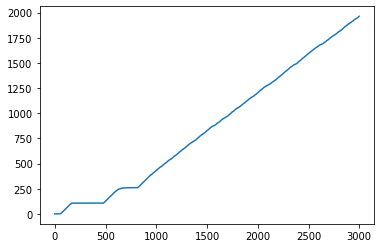

In [100]:
plt.plot(np.cumsum(trainer.mem_total_reward))

(0.0, 3000.0)

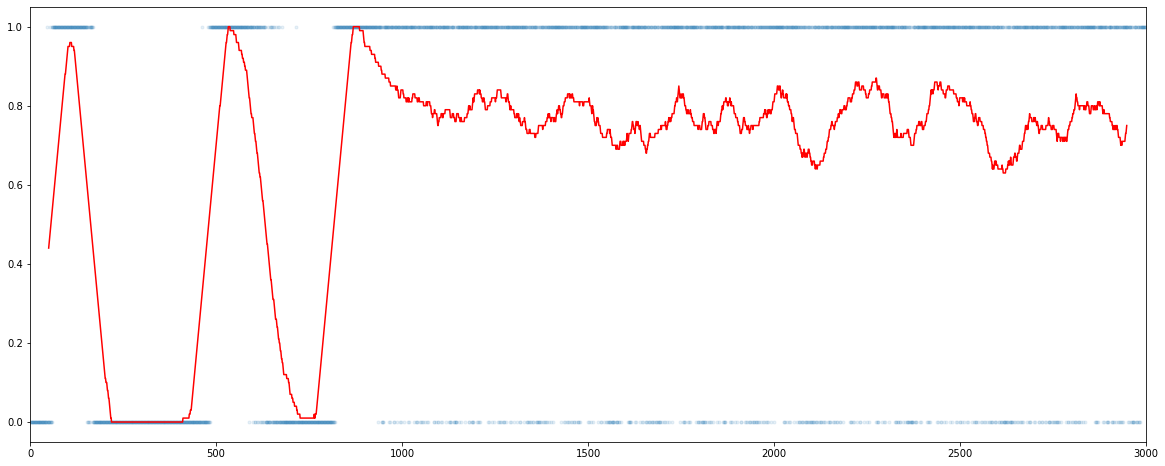

In [101]:
plt.figure(figsize=(20,8))
plt.plot(trainer.mem_total_reward,'.',alpha=.1)
plt.plot(range(50, N-51), np.convolve(trainer.mem_total_reward, np.ones(100)/100)[100:-100], 'r')
plt.xlim(0,N)

(0.0, 3000.0)

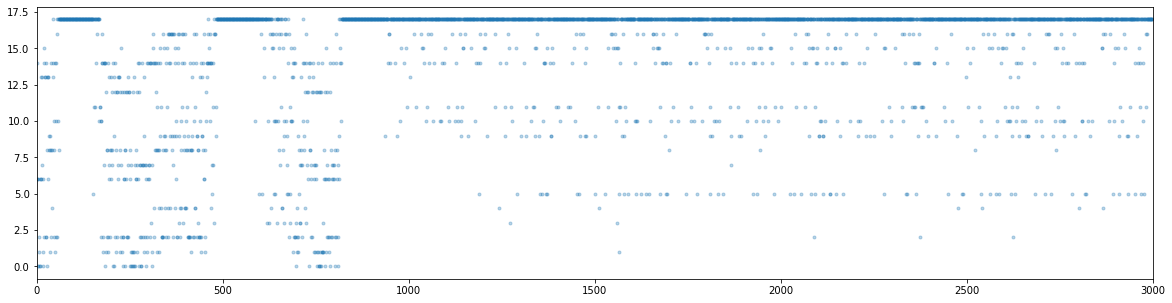

In [102]:
plt.figure(figsize=(20,5)); ax=plt.subplot(111)
ax.plot(trainer.mem_obs_final, '.', alpha=.3)
ax.set_xlim(0,N)

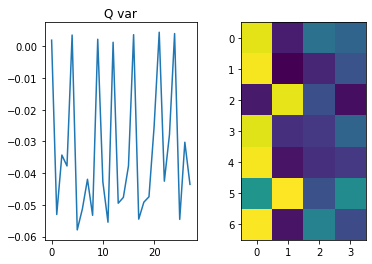

In [103]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab[:8,:])

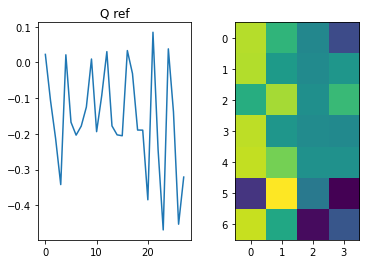

In [104]:
plt.subplot(1,2,1)
plt.plot(agent.Q_ref_tab.flatten())
plt.title('Q ref')
plt.subplot(1,2,2)
plt.imshow(agent.Q_ref_tab[:8,:])

In [105]:
mem_Q_var_arr = np.array(mem_Q_var)

In [106]:
mem_Q_var_flat = mem_Q_var_arr.reshape((trainer.nb_trials, -1))

(0.0, 3000.0)

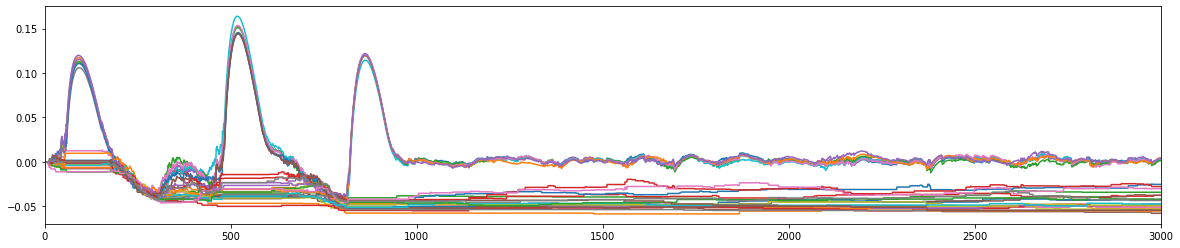

In [107]:
plt.figure(figsize=(20,4)); ax=plt.subplot(111)
ax.plot(mem_Q_var_flat)
ax.set_xlim(0,trainer.nb_trials)

(0.0, 3000.0)

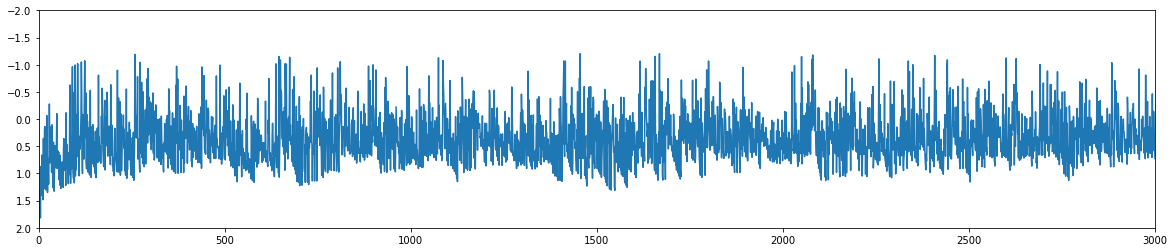

In [108]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_KL)
ax.set_ylim(2,-2)
ax.set_xlim(0,trainer.nb_trials)

(0.0, 3000.0)

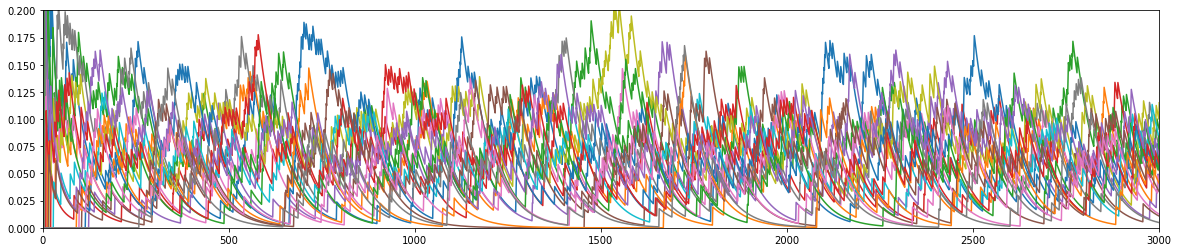

In [109]:
plt.figure(figsize=(20,4))
ax=plt.subplot(111)
ax.plot(mem_p_eff.T)
ax.set_ylim(0,.2)
ax.set_xlim(0,trainer.nb_trials)

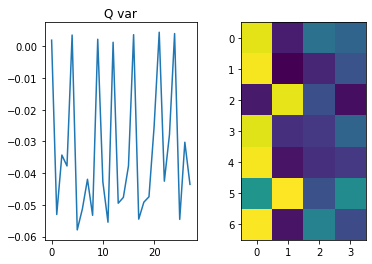

In [110]:
plt.subplot(1,2,1)
plt.plot(agent.Q_var_tab.flatten())
plt.title('Q var')
plt.subplot(1,2,2)
plt.imshow(agent.Q_var_tab)

In [111]:
trial=0
v_min=0
v_max = 0.16
savefigs = False

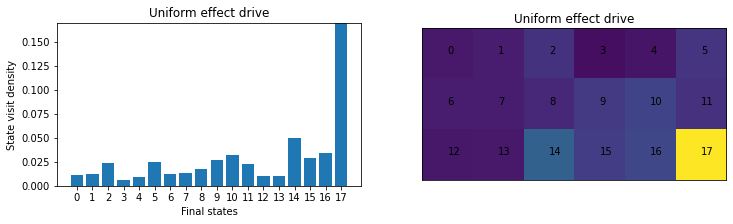

In [115]:
plt.figure(figsize = (12,3))
ax = plt.subplot(1,2,1)
plt.bar(range(env.N_obs), nb_visits_final[trial] / N)
ax.set_xticks(range(18))
plt.xlabel('Final states')
plt.ylabel('State visit density')
plt.ylim([0,0.17])
plt.title('Uniform effect drive')

ax = plt.subplot(1,2,2)
plt.imshow(nb_visits_final[trial].reshape(3,6)/ N, vmin=v_min, vmax=v_max)
for j in range(6):
    for i in range(3):
        plt.text(j,i,6*i+j)

ax.set_xticks([])
ax.set_yticks([])
plt.title('Uniform effect drive')

if savefigs:
    plt.savefig('botteneck-uniform-drive.png', bbox_inches='tight')

In [2190]:
trainer.nb_trials

20000

In [2191]:
obs_nb_visit = np.zeros((env.N_obs, trainer.nb_trials))
obs_p = np.zeros((env.N_obs, trainer.nb_trials))
for obs in range(env.N_obs):
    obs_nb_visit[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs)
    obs_p[obs,:] = np.cumsum(np.array(trainer.mem_obs_final)==obs) / (np.arange(trainer.nb_trials)+1)
    

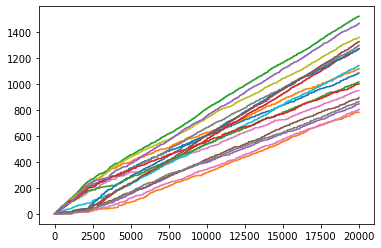

In [2192]:
_ = plt.plot(obs_nb_visit.T)

(0.0, 0.2)

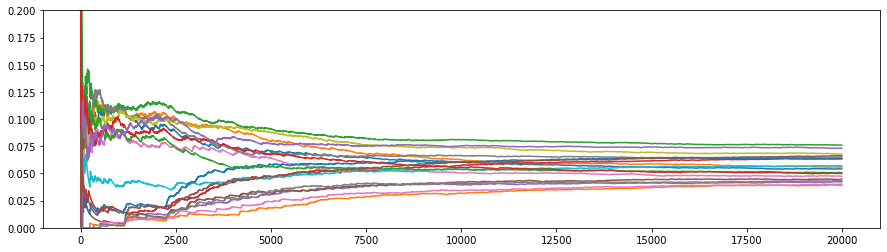

In [2193]:
plt.figure(figsize=(15,4))
plt.plot(obs_p.T)
plt.ylim((0,0.2))

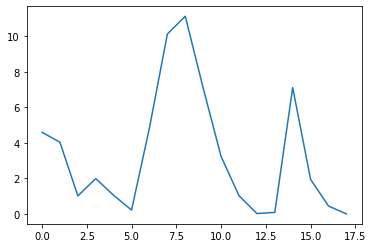

In [2194]:
plt.plot(trainer.obs_score)

In [2195]:
trainer.ref_probs

array([0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556])

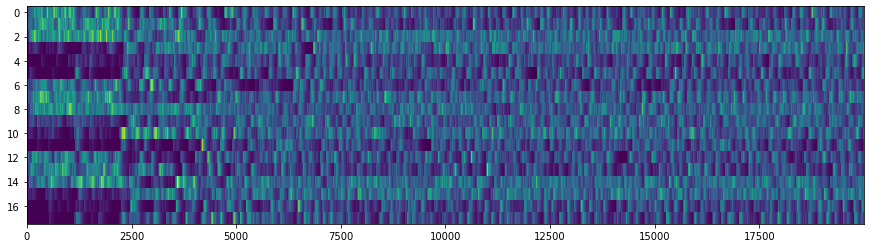

In [2196]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_obs_score, aspect='auto', interpolation='nearest')

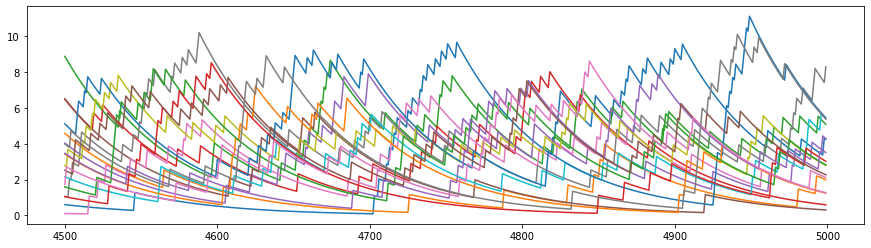

In [2197]:
plt.figure(figsize=(15,4))
plt.plot(range(4500,5000), mem_obs_score[:,4500:5000].T)

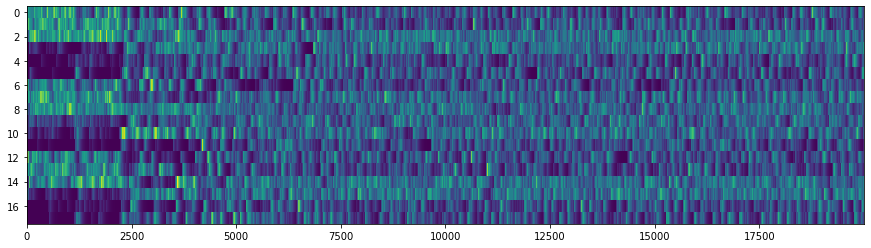

In [2198]:
plt.figure(figsize=(15,4))
_ = plt.imshow(mem_p_eff, aspect='auto', interpolation='nearest', vmin=0, vmax=0.2)

(4500.0, 5000.0)

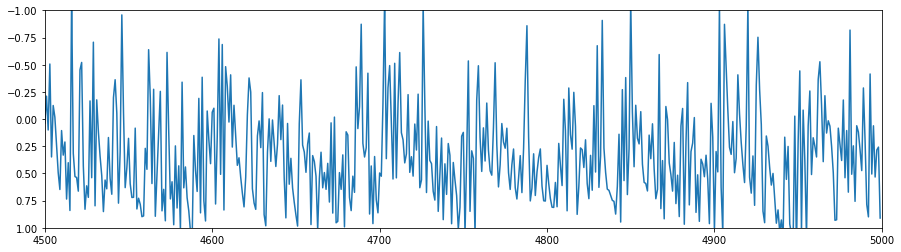

In [2199]:
plt.figure(figsize=(15,4))
ax=plt.subplot(111)
ax.plot(range(4500,5000), mem_KL[4500:5000])
ax.set_ylim(1,-1)
ax.set_xlim(4500,5000)

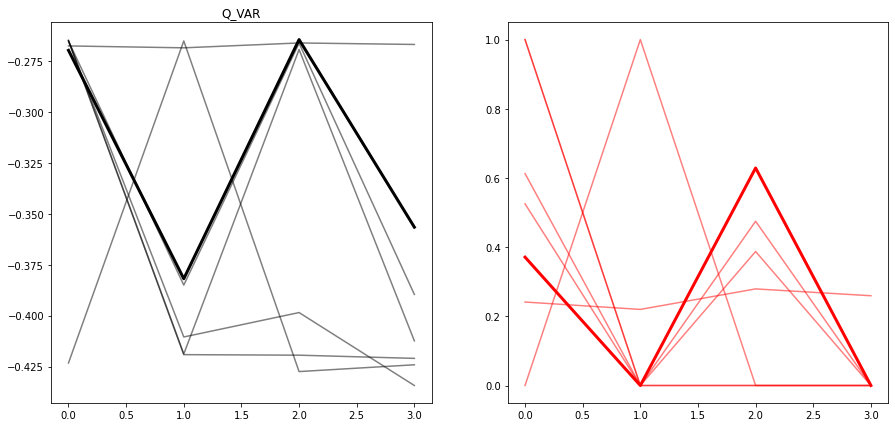

In [2200]:
#obs = trainer.agent.get_observation()
plt.figure(figsize=(15,7))
ax1=plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
for obs in range(7):
    actions_set = None #trainer.set_actions_set()
    #print(actions_set)
    Q_obs = trainer.agent.set_Q_obs(obs, actions_set = actions_set)
    ax1.plot(Q_obs,'k',alpha=.5)    
    ax1.set_title('Q_VAR') # : MEAN RTG :' + str(m_rtg))
    ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', alpha=.5)
#ax1.plot((1,trainer.N_PART), (m_rtg, m_rtg), 'r')
ax1.plot(Q_obs,'k',linewidth=3)
ax2.plot(agent.softmax(obs, actions_set=actions_set), 'r', linewidth=3)

## TRIAL

0


/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'TRIAL : ACTION')

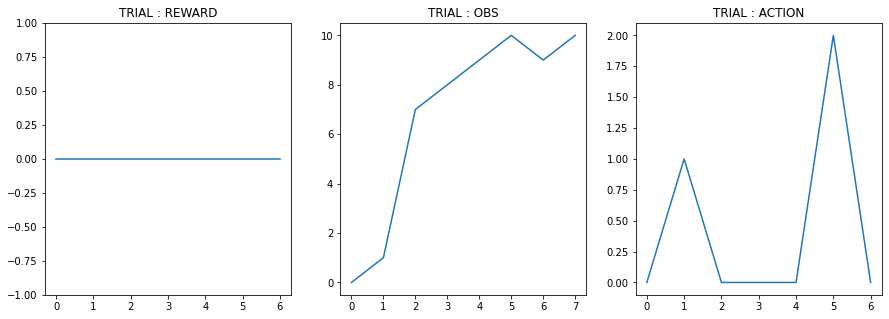

In [2201]:
%matplotlib tk
#agent.env=env
trainer.run_episode(render=True)

%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(trainer.reward_history)
plt.ylim(-1,1)
plt.title('TRIAL : REWARD')
plt.subplot(1,3,2)
plt.plot(trainer.trajectory)
print(trainer.total_reward)
plt.title('TRIAL : OBS')
plt.subplot(1,3,3)
plt.plot(trainer.action_history)
plt.title('TRIAL : ACTION')
#obs = trainer.agent.get_observation()


In [2202]:
100 / 18

5.555555555555555

In [2203]:
int(args.ALPHA//(args.OBS_LEAK * 18))

1

In [2204]:
for i in range(0):
    print('ok')

In [2205]:
18 / args.ALPHA

60.0

In [2206]:
1/args.OBS_LEAK

60.0

In [2207]:
1 / ( 1e-3 * 5)

200.0

In [2208]:
args.ALPHA / 18

0.016666666666666666